In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp

In [2]:
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: C:\Users\39339\.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


True

In [2]:
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [64]:
X = pd.read_csv("../Datasets/covariates.csv")

In [65]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')

In [66]:
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)

In [67]:
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [68]:
rows_to_drop_Y = Y[Y['Count_180'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [69]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]


In [70]:
len(stations)

3808

In [71]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;


  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  // array[N] int<lower=4, upper=10> month;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    vector[N] intercept;
    vector[N] fix_eff;

    intercept = xi[year] + eta[station];
    fix_eff = X * beta;

    lambda = exp(intercept + fix_eff);
}

model {

  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);


}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

11:42:04 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\base.exe
11:42:34 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\base.exe


In [72]:
X = X.drop(['Year','Station','Month'], axis  = 1)

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [74]:
data = {
    "N": len(Y),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X_std
}


fit = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az = az.from_cmdstanpy(fit)

11:42:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:33 - cmdstanpy - INFO - CmdStan done processing.


11:44:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 2 iterations at max treedepth (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


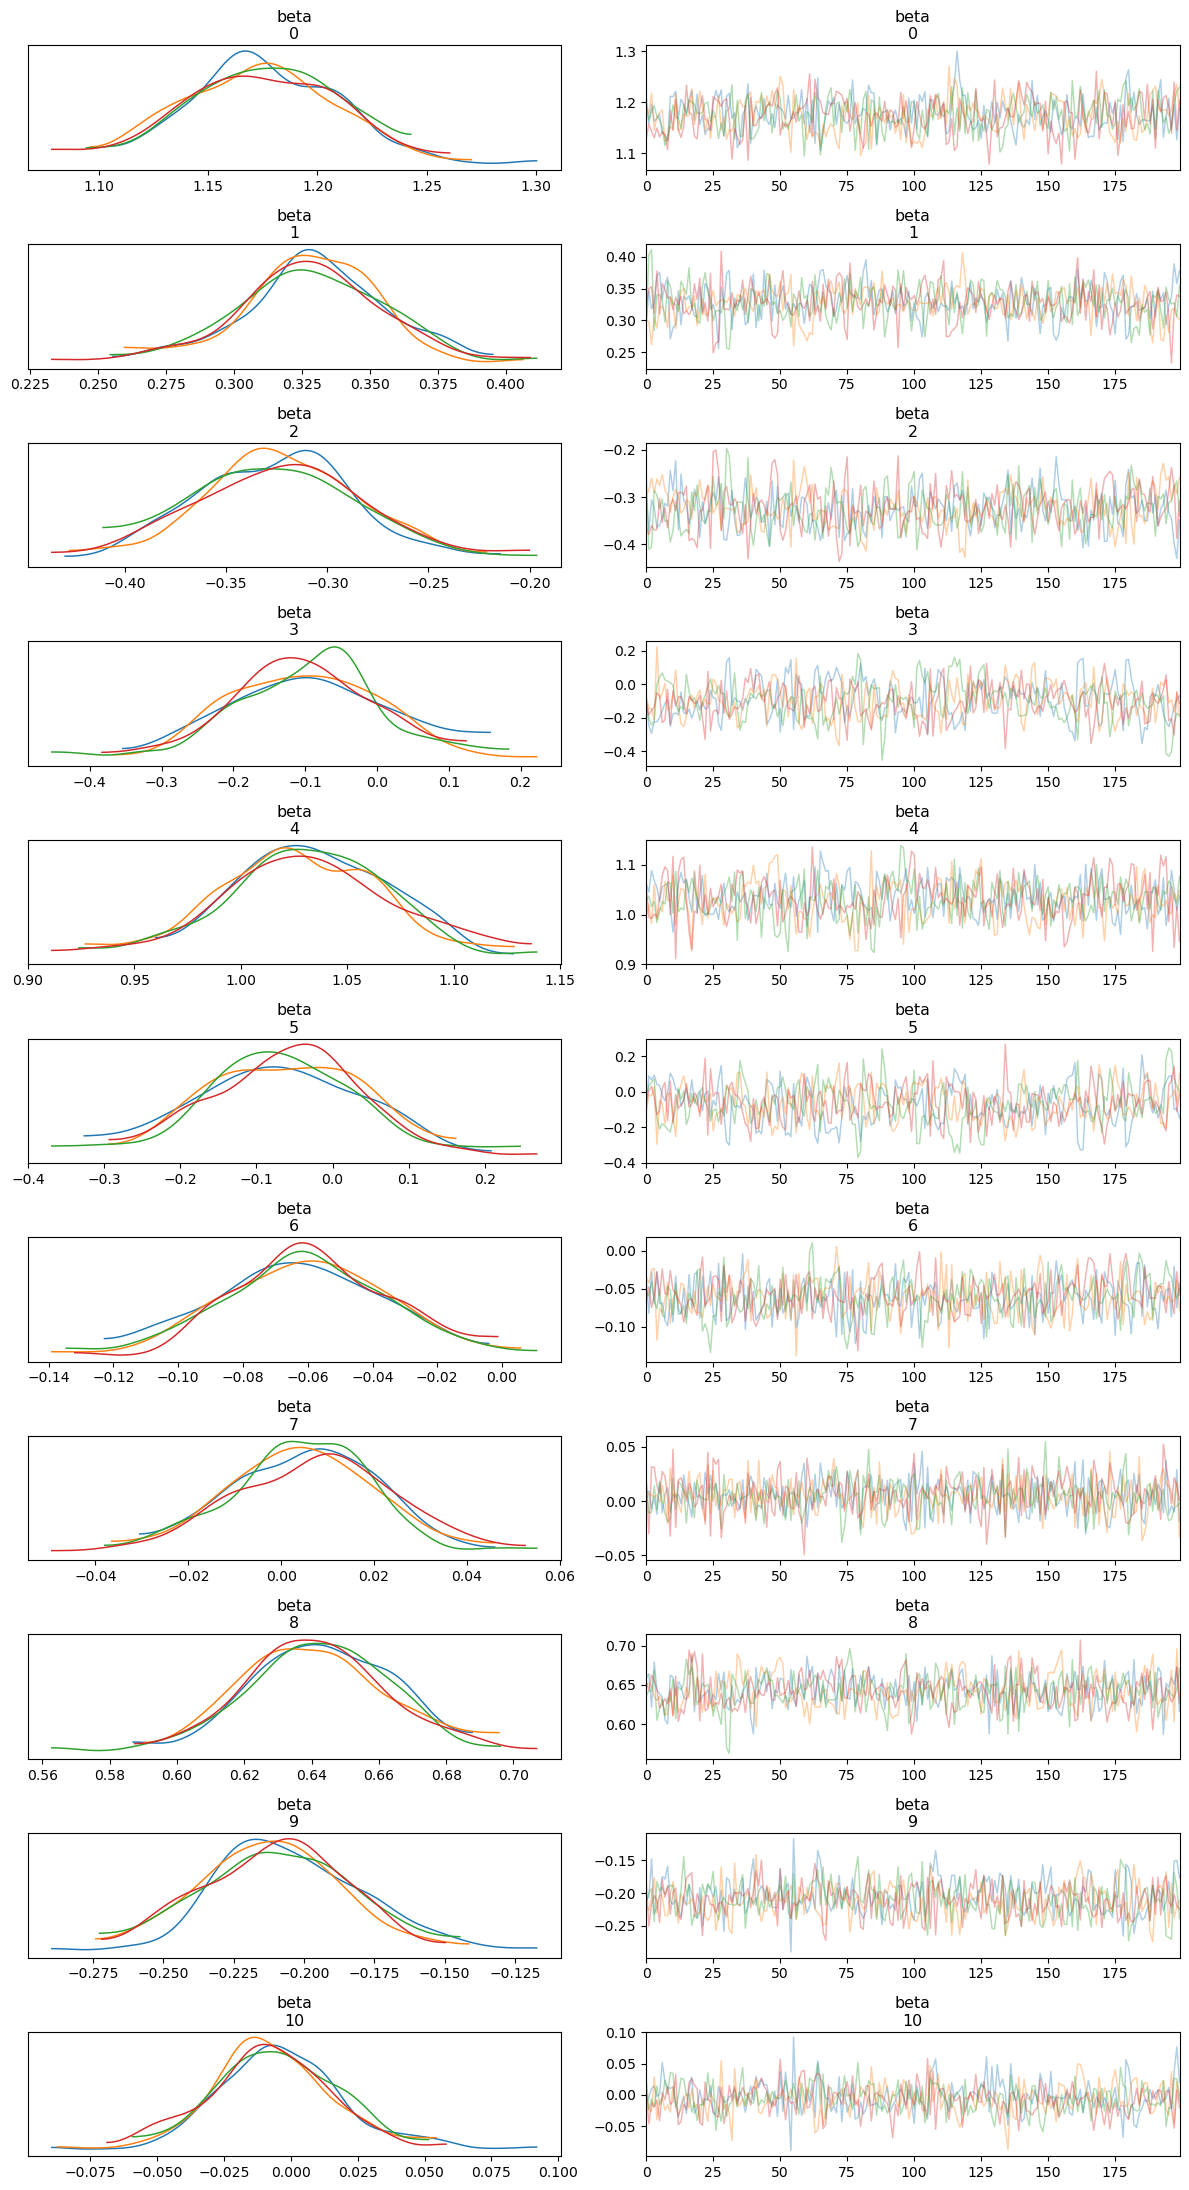

In [14]:
az.plot_trace(posterior_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [32]:
lam = posterior_az['posterior']['lambda']
lam

<xarray.DataArray 'lambda' (chain: 4, draw: 200, lambda_dim_0: 3808)>
array([[[0.0768491, 0.300297 , 1.68818  , ..., 1.06352  , 0.0636424,
         0.0165031],
        [0.0842577, 0.320667 , 1.92821  , ..., 0.97908  , 0.0621208,
         0.0156135],
        [0.0746464, 0.313615 , 1.75481  , ..., 1.08068  , 0.0669837,
         0.0171298],
        ...,
        [0.0909727, 0.344043 , 1.95914  , ..., 0.94454  , 0.0605804,
         0.0161528],
        [0.0873781, 0.296276 , 1.76714  , ..., 1.1366   , 0.0719604,
         0.0210424],
        [0.0917451, 0.322975 , 1.93296  , ..., 1.09256  , 0.0693526,
         0.0189312]],

       [[0.0660286, 0.286676 , 1.81135  , ..., 0.998139 , 0.0527237,
         0.013064 ],
        [0.0699329, 0.32908  , 1.91789  , ..., 1.1759   , 0.062915 ,
         0.0132463],
        [0.0613471, 0.267382 , 1.75811  , ..., 1.07409  , 0.0566125,
         0.013669 ],
...
        [0.0905381, 0.356298 , 1.91049  , ..., 1.04476  , 0.0635729,
         0.0164589],
        [0.0879122, 0.373146 , 1.98133  , ..., 1.16418  , 0.0697006,
         0.0170012],
        [0.0810033, 0.291155 , 1.77833  , ..., 1.01467  , 0.0641312,
         0.0161465]],

       [[0.0796421, 0.292225 , 1.7306   , ..., 1.00917  , 0.0652525,
         0.0183798],
        [0.0972435, 0.375253 , 2.00736  , ..., 1.18939  , 0.077494 ,
         0.0193853],
        [0.0912816, 0.31255  , 1.77577  , ..., 1.00292  , 0.0665848,
         0.0193243],
        ...,
        [0.0763429, 0.316102 , 1.75264  , ..., 0.947491 , 0.0590691,
         0.0145685],
        [0.087267 , 0.333496 , 1.9985   , ..., 0.996529 , 0.0585721,
         0.0145512],
        [0.0803872, 0.281913 , 1.78576  , ..., 0.967029 , 0.0566275,
         0.014707 ]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * lambda_dim_0  (lambda_dim_0) int32 0 1 2 3 4 5 ... 3803 3804 3805 3806 3807

In [106]:
inference = []
for i in range(len(Y['Count_180'])):
    ar1 = lam[0, :, i] - Y['Count_180'][i]
    ar2 = lam[1, :, i] - Y['Count_180'][i]
    ar3 = lam[2, :, i] - Y['Count_180'][i]
    ar4 = lam[3, :, i] - Y['Count_180'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)


3808

In [108]:
df = pd.DataFrame(inference).transpose()
df.shape

(800, 3808)

In [112]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)


Current Working Directory: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello


In [113]:
csv_path = '../Datasets/Residuals.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [42]:
np.unique(stations)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [40]:
posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [75]:
eta = posterior_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [76]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [77]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [79]:
csv_path = '../Datasets/eta_180.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)